In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import xarray as xr
import os
import datetime
from datetime import datetime
from scipy import interpolate
from scipy.interpolate import griddata
import netCDF4 as nc4
from netCDF4 import Dataset
import xesmf as xe
import matplotlib.dates as mdates
import cmaps
import regionmask
import gcpy

from scipy import stats
import matplotlib.pyplot as plt
from pylib.smafit import smafit
import statsmodels.formula.api as smf

land = regionmask.defined_regions.natural_earth.land_110

def file_list(dirname, ext='.csv'):
    import os
    return list(filter(
        lambda filename: os.path.splitext(filename)[1] == ext,
        os.listdir(dirname)))

import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.cm as cm
xlabelfont = {'family' : 'DejaVu Sans',
              'weight' : 'normal',
              'size'   : 16 ,
             }
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

/home/tzhao/Software/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
hour1 = 12+8
hour2 = 15+8

def selnoon(x,hour1,hour2,year):
    x_noon = x.where( (x.time.dt.hour>=hour1) &\
            (x.time.dt.hour<=hour2) &\
            (x.time.dt.year==year) &\
            (x.time.dt.month>=5) &\
            (x.time.dt.month<=8) )
    return x_noon


        
def mjja(var,tmp_title,vminmax,unitname,cmapname):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm

    xlabelfont = {
    'weight' : 'normal',
    'size'   : 22,
    }
    monname = ["May","June","July","August"]
    figsize=(32,8)

    
    for ivar in range(0,len(var)):


        # monthly mean variable
        mm_HCHOVCD = var[ivar].resample(time="1MS").mean(dim="time")   # 5678


        nrow = 1
        ncol = 4


        ipanel = 0
        ipanelindex = np.arange(1,1+nrow*ncol,1)

        fig = plt.figure(figsize=figsize)
        for imon in range(5,9): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(lon_gc_AK, lat_gc_AK, mm_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)
#             if ipanelindex[ipanel]==3:
#                 cb = plt.colorbar(mappable)
#                 cb.set_label('moles/cm^2',fontdict=xlabelfont)

            # add lat lon label
            ax.set_xticks([-160,-150,-140,-130], crs=ccrs.PlateCarree())
            if ipanelindex[ipanel]==1:
                ax.set_yticks([50,55,60,65,70,75], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ipanel+=1



        import matplotlib.ticker                         # here's where the formatter is
        cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
        cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
        position=fig.add_axes([0.91, 0.65, 0.005, 0.23])
        cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
        cb.set_label(unitname[ivar])


        fig.tight_layout()#调整整体空白 
        plt.subplots_adjust(wspace =0.01, hspace =0.1)#调整子图间距
        # plt.savefig(outdir+'GCAvk_vs_TPM_AK_18',dpi=300)
        

###############################################################


def mjja_err(var,tmp_title,vminmax,unitname,cmapname):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm

    xlabelfont = {
    'weight' : 'normal',
    'size'   : 22,
    }
    monname = ["May","June","July","August"]
    figsize=(32,8)

    
    for ivar in range(0,len(var)):

        # count value numbers
        count_HCHOVCD = var[ivar].resample(time="1MS").count(dim="time")
        # monthly mean variable
        mm_HCHOVCD = var[ivar].resample(time="1MS").mean(dim="time")   # 5678
        
        # Monthly Error
        mErr_HCHOVCD = mm_HCHOVCD/np.sqrt(count_HCHOVCD)   # 5678


        nrow = 1
        ncol = 4


        ipanel = 0
        ipanelindex = np.arange(1,1+nrow*ncol,1)

        fig = plt.figure(figsize=figsize)
        for imon in range(5,9): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(lon_gc_AK, lat_gc_AK, mErr_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)
#             if ipanelindex[ipanel]==3:
#                 cb = plt.colorbar(mappable)
#                 cb.set_label('moles/cm^2',fontdict=xlabelfont)

            # add lat lon label
            ax.set_xticks([-160,-150,-140,-130], crs=ccrs.PlateCarree())
            if ipanelindex[ipanel]==1:
                ax.set_yticks([50,55,60,65,70,75], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ipanel+=1



        import matplotlib.ticker                         # here's where the formatter is
        cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
        cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
        position=fig.add_axes([0.91, 0.65, 0.005, 0.23])
        cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
        cb.set_label(unitname[ivar])


        fig.tight_layout()#调整整体空白 
        plt.subplots_adjust(wspace =0.01, hspace =0.1)#调整子图间距
        # plt.savefig(outdir+'GCAvk_vs_TPM_AK_18',dpi=300)
        

###############################################################
        
def mjja_diff(var,tmp_title,vminmax,unitname,cmapname):
    
    
    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm

    xlabelfont = {
    'weight' : 'normal',
    'size'   : 22,
    }
    monname = ["May","June","July","August"]
    figsize=(32,8)

    mpl.rc('xtick', labelsize=18) 
    mpl.rc('ytick', labelsize=18) 
    
    
    
    
    for ivar in range(0,len(var)):


        # monthly mean variable
        if type(var[ivar][0])==np.ndarray:
            mm_HCHOVCD = var[ivar][0] - var[ivar][1]   # 5678
        elif type(var[ivar][0])==xr.core.dataarray.DataArray:
            mm_HCHOVCD = var[ivar][0].resample(time="1MS").mean(dim="time") - var[ivar][1].resample(time="1MS").mean(dim="time")   # 5678


        nrow = 1
        ncol = 4


        ipanel = 0
        ipanelindex = np.arange(1,1+nrow*ncol,1)

        fig = plt.figure(figsize=figsize)
        for imon in range(5,9): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(lon_gc_AK, lat_gc_AK, mm_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)
        #     if ipanelindex[ipanel]==3:
        #     cb = plt.colorbar(mappable)
        #     cb.set_label('moles/cm^2',fontdict=xlabelfont)

            # add lat lon label
            ax.set_xticks([-160,-150,-140,-130], crs=ccrs.PlateCarree())
            if ipanelindex[ipanel]==1:
                ax.set_yticks([50,55,60,65,70,75], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ipanel+=1



        import matplotlib.ticker                         # here's where the formatter is
        cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
        cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
        position=fig.add_axes([0.91, 0.65, 0.005, 0.23])
        cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
        cb.set_label(unitname[ivar])


        fig.tight_layout()#调整整体空白 
        plt.subplots_adjust(wspace =0.01, hspace =0.1)#调整子图间距
        # plt.savefig(outdir+'GCAvk_vs_TPM_AK_18',dpi=300)        

        
def calbox(clat,clon,km):
    import math

#     clat = 64.8
#     clon = -147.7A
#     km = 30

    cos_clat = math.cos(clat*math.pi/180)
    dlon = km/(111*cos_clat)
    dlat = km/111

    latN = clat + dlat/2
    latS = clat - dlat/2
    latrange = [latS, latN]

    lonE = clon + dlon/2
    lonW = clon - dlon/2
    lonrange = [lonW, lonE]
    
    return latrange, lonrange



# ISOP- HCHO linear regression




def bvoc_hcho_noon(var_BVOCe_HCHOVCD_ts, years, titles,legends,xlims,ylims,flag):
    
    from scipy import stats
    import matplotlib.pyplot as plt
    from pylib.smafit import smafit
    import statsmodels.formula.api as smf
    import numpy.ma as ma

    
    for ivar in range(0,len(var_BVOCe_HCHOVCD_ts)):
        fig = plt.figure()

        hour1 = 12+8
        hour2 = 15+8
        tmp_BVOCemisnoon = selnoon(var_BVOCe_HCHOVCD_ts[ivar][0] ,hour1,hour2,years[ivar])*6.02e23/12e-3/1e4 /1e13
        tmp_gcnoon = selnoon( var_BVOCe_HCHOVCD_ts[ivar][1] ,hour1,hour2,years[ivar]) /1e16
        
        if flag == "AK":
            land = regionmask.defined_regions.natural_earth.land_110
            tmp_BVOCemisnoon = tmp_BVOCemisnoon.resample(time="5D").mean(dim='time')
            tmp_BVOCemisnoon = tmp_BVOCemisnoon.where(land.mask_3D(tmp_BVOCemisnoon)).squeeze().values
            tmp_BVOCemisnoon = tmp_BVOCemisnoon[~np.isnan(tmp_BVOCemisnoon)]

            
            tmp_gcnoon = tmp_gcnoon.resample(time="5D").mean(dim='time')
            tmp_gcnoon = tmp_gcnoon.where(land.mask_3D(tmp_gcnoon)).squeeze().values
            tmp_gcnoon = tmp_gcnoon[~np.isnan(tmp_gcnoon)]
                        
        
#         # SMA fit, use robust methods to minimize effect of outliers
#         s,i,stds,stdi,cis,cii = smafit(  tmp_BVOCemisnoon  ,  tmp_gcnoon  ,cl=0.95,robust=True)
#         # OLS for comparison
#         res = smf.ols('y ~ x + 1',{'x':tmp_BVOCemisnoon, 'y':tmp_gcnoon}).fit()
#         fmt = '{:15s}{:8.2e}  +/-  {:8.2e}'
        
        # Least Square Linear regression
        s,i,r_value, p_value, std_err = stats.linregress(  tmp_BVOCemisnoon  ,  tmp_gcnoon  )


        plt.rcParams['figure.figsize'] = (10.0, 8.0)
        plt.scatter(tmp_BVOCemisnoon , tmp_gcnoon,   color='red')  # GC
        plt.gca().legend((legends[ivar],''),fontsize=16,loc='upper right')
        
        plt.plot(  np.linspace(xlims[ivar][0],xlims[ivar][1],100 ) ,\
                 np.linspace(s * xlims[ivar][0] + i , s * xlims[ivar][1] + i, 100) ,'k')


        plt.ylim(ylims[ivar])
        plt.xlim(xlims[ivar])
        plt.xlabel("1e13 atomsC/cm^2/s" )
        plt.ylabel("1e16 molecules/cm^2")
        plt.title(titles[ivar])

        
        
        R = ma.corrcoef(ma.masked_invalid(tmp_BVOCemisnoon), ma.masked_invalid(tmp_gcnoon))[0,1]
        plt.text( xlims[ivar][1]*0.02 , ylims[ivar][1]*0.95 , "R = " + str(format(R, '.3g')), fontsize=20)
        plt.text( xlims[ivar][1]*0.02 , ylims[ivar][1]*0.90, "Y = " + str(format(s, '.3g')) + " X + " + str(format(i, '.2g')) , fontsize=20)
        
        ax=fig.gca()
        ax.yaxis.set_ticks_position('right') 
        


def lev_2_pressure(refdata):
    ref_vert_params=[[], []]
    pres_range=[0, 2000]
    ref_pedge, ref_pmid, _ = gcpy.grid.get_vert_grid(refdata, *ref_vert_params)
    ref_pedge_ind = gcpy.grid.get_pressure_indices(ref_pedge, pres_range)

    ref_pedge_ind =  gcpy.grid.pad_pressure_edges(
        ref_pedge_ind,
        refdata.sizes["lev"],
        np.size(ref_pmid))

    ref_pmid_ind = ref_pedge_ind[:-1]

    refdata_2 = gcpy.grid.convert_lev_to_pres(refdata, ref_pmid, ref_pedge)
    return refdata_2

In [2]:
jndir = "/import/GREENING/tzhao/jndata/TROPOMI_HCHO/"
jndirCO = "/import/GREENING/tzhao/jndata/TROPOMI_CO/"
jndirPdr = "/import/GREENING/tzhao/jndata/Pandora/"
jndirGC = "/import/GREENING/tzhao/jndata/GEOS-Chem/"
jndirGC_NoWF = jndirGC+"MEGANon_PFTol_NoWF/"
jndirGC_WF = jndirGC+"MEGANon_PFTol_WF/"
jndirGC_BVOCe_off_WF = jndirGC+"BVOCoff_PFTol_WF/"
jndirGC_BVOCe_off_NoWF = jndirGC+"BVOCoff_PFTol_NoWF/"
jndirGC_BVOCe_off_WEFHCHOoff = jndirGC+"BVOCoff_PFTol_WEFHCHOoff/"
jndirGC_BVOCe_off_NoWF_BCNoWF = jndirGC+"BVOCoff_PFTol_NoWF_BCNoWF/"

workdir = "/home/tzhao/my_jupyter_work/newest/"
# lat, lon 0.5x0.625
###############################################################################
lat_gc_AK = np.load(jndir+'lat_gc_AK_050625.npy')
lon_gc_AK = np.load(jndir+'lon_gc_AK_050625.npy')

TPM_hsigma = xr.open_dataset(jndir+"TROPOMI_hsigma.nc", engine="netcdf4")
b_tpm = TPM_hsigma["b_tpm"]
ap_tpm = TPM_hsigma["ap_tpm"]

H_b_gc = xr.open_dataarray(jndirGC+"H_b_gc.nc", engine="netcdf4")

In [4]:
# new colormap

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = cmaps.GHRSST_anomaly
newcolors=cmap(np.linspace(0, 1, 256))
GHRSST_pos = ListedColormap(newcolors[128:])

In [5]:
# read in data

#############  GEOS-Chem  ##################

# Met
Met_BXHEIGHT_18 = xr.open_dataarray(jndirGC_WF+"Met_BXHEIGHT_18.nc", engine="netcdf4")
Met_AIRDEN_18 = xr.open_dataarray(jndirGC_WF+"Met_AIRDEN_18.nc", engine="netcdf4")
Met_PBLH_18 = xr.open_dataarray(jndirGC_WF+"Met_PBLH_18.nc", engine="netcdf4")
Met_SLP_18 = xr.open_dataarray(jndirGC_WF+"Met_SLP_18.nc", engine="netcdf4")
Met_T_18 = xr.open_dataarray(jndirGC_WF+"Met_T_18.nc", engine="netcdf4")

Met_BXHEIGHT_19 = xr.open_dataarray(jndirGC_WF+"Met_BXHEIGHT_19.nc", engine="netcdf4")
Met_AIRDEN_19 = xr.open_dataarray(jndirGC_WF+"Met_AIRDEN_19.nc", engine="netcdf4")
Met_PBLH_19 = xr.open_dataarray(jndirGC_WF+"Met_PBLH_19.nc", engine="netcdf4")
Met_SLP_19 = xr.open_dataarray(jndirGC_WF+"Met_SLP_19.nc", engine="netcdf4")
Met_T_19 = xr.open_dataarray(jndirGC_WF+"Met_T_19.nc", engine="netcdf4")

ap_gc = xr.open_dataarray(jndirGC+"ap_gc.nc", engine="netcdf4")
b_gc = xr.open_dataarray(jndirGC+"b_gc.nc", engine="netcdf4")


# Species    ( No Wildfire )
SpeciesConc_CH2O_18_NoWF = xr.open_dataarray(jndirGC_NoWF+"SpeciesConc_CH2O_18.nc", engine="netcdf4")
SpeciesConc_CH2O_19_NoWF = xr.open_dataarray(jndirGC_NoWF+"SpeciesConc_CH2O_19.nc", engine="netcdf4")
# Species    ( Wildfire )
SpeciesConc_CH2O_18_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_CH2O_18.nc", engine="netcdf4")
SpeciesConc_CH2O_19_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_CH2O_19.nc", engine="netcdf4")
SpeciesConc_ISOP_18_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_ISOP_18.nc", engine="netcdf4")
SpeciesConc_ISOP_19_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_ISOP_19.nc", engine="netcdf4")
SpeciesConc_MTPA_18_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_MTPA_18.nc", engine="netcdf4")
SpeciesConc_MTPA_19_WF = xr.open_dataarray(jndirGC_WF+"SpeciesConc_MTPA_19.nc", engine="netcdf4")




# BVOC Emission
EmisISOP_Total_18 = xr.open_dataarray(jndirGC_NoWF+"EmisISOP_Total_18.nc", engine="netcdf4")
EmisMTPA_Total_18 = xr.open_dataarray(jndirGC_NoWF+"EmisMTPA_Total_18.nc", engine="netcdf4")

EmisISOP_Total_19 = xr.open_dataarray(jndirGC_NoWF+"EmisISOP_Total_19.nc", engine="netcdf4")
EmisMTPA_Total_19 = xr.open_dataarray(jndirGC_NoWF+"EmisMTPA_Total_19.nc", engine="netcdf4")

#############  TROPOMI GCHiR   ##################
TPM_19 = xr.open_dataset(jndir+"TROPOMI_HCHO_GCHiR_hr_19_Fullrange__AddHiR.nc", engine="netcdf4")
HCHOVCD_TPM_19 = TPM_19["HCHOVCD_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']
HCHOVCD_err_TPM_19 = TPM_19["HCHOVCD_err_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']
AMF_HCHO_trop_TPM_19 = TPM_19["AMF_HCHO_trop_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']
HCHOSCD_corr_TPM_19 = TPM_19["HCHOSCD_corr_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']
HCHOVCD0_TPM_19 = TPM_19["HCHOVCD0_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']

TPM_18 = xr.open_dataset(jndir+"TROPOMI_HCHO_GCHiR_hr_18_Fullrange.nc", engine="netcdf4")
HCHOVCD_TPM_18 = TPM_18["HCHOVCD_TPM_GCHiR"]
HCHOVCD_err_TPM_18 = TPM_18["HCHOVCD_err_TPM_GCHiR"]
AMF_HCHO_trop_TPM_18 = TPM_18["AMF_HCHO_trop_TPM_GCHiR"]
HCHOSCD_corr_TPM_18 = TPM_18["HCHOSCD_corr_TPM_GCHiR"]
HCHOVCD0_TPM_18 = TPM_18["HCHOVCD0_TPM_GCHiR"]

# Averaging Kernel of TROPOMI
TPM_AvK_18 = xr.open_dataset(jndir+"TROPOMI_AvKapri_GCHiR_hr_18_Fullrange.nc", engine="netcdf4")
HCHOAvK_TPM_18 = TPM_AvK_18["AveragingKernel_TPM_GCHiR"]

TPM_AvK_19 = xr.open_dataset(jndir+"TROPOMI_AvKapri_GCHiR_hr_19_Fullrange__AddHiR.nc", engine="netcdf4")
HCHOAvK_TPM_19 = TPM_AvK_19["AveragingKernel_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-31T23:00:00']



# read GC AMF
AMF_GC_18_NoWF = xr.open_dataarray(jndirGC_NoWF+"AMF_GC_18.revised.2.nc", engine="netcdf4")
AMF_GC_19_NoWF = xr.open_dataarray(jndirGC_NoWF+"AMF_GC_19.revised.2.nc", engine="netcdf4")
AMF_GC_18_WF = xr.open_dataarray(jndirGC_WF+"AMF_GC_18.revised.2.nc", engine="netcdf4")
AMF_GC_19_WF = xr.open_dataarray(jndirGC_WF+"AMF_GC_19.revised.2.nc", engine="netcdf4")

###############################################################################################
# read MAX-DOAS
ds_MDS_FA = xr.open_dataset(jndir+"MAXDOAS_FA_HCHO_geom.nc", engine="netcdf4")
HCHOVCD_MDS_FA = ds_MDS_FA["hcho_geom_vcd"]
ds_MDS_TK_19 = xr.open_dataset(jndir+"MAXDOAS19TK_HCHO_geom_NoWF.nc", engine="netcdf4")
HCHOVCD_MDS_TK = ds_MDS_TK_19["hcho_geom_vcd"]

In [6]:
# uncertainty/Error

TPM_Err_18 = xr.open_dataset(jndir+"TROPOMI_HCHOError_GCHiR_hr_18_Fullrange.nc", engine="netcdf4")

HCHOVCD_Trueness_TPM_18 = TPM_Err_18["HCHOVCD_Trueness_TPM_GCHiR"]
HCHOSCD_corr_Trueness_TPM_18 = TPM_Err_18["HCHOSCD_corr_Trueness_TPM_GCHiR"]
AMF_HCHO_trop_Trueness_TPM_18 = TPM_Err_18["AMF_HCHO_trop_Trueness_TPM_GCHiR"]
HCHOVCD_Precision_TPM_18 = TPM_Err_18["HCHOVCD_Precision_TPM_GCHiR"]
AMF_HCHO_trop_Precision_TPM_18 = TPM_Err_18["AMF_HCHO_trop_Precision_TPM_GCHiR"]

TPM_Err_19 = xr.open_dataset(jndir+"TROPOMI_HCHOError_GCHiR_hr_19_Fullrange.nc", engine="netcdf4")

HCHOVCD_Trueness_TPM_19 = TPM_Err_19["HCHOVCD_Trueness_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-05T22:00:00']*6.02e23*1e-4
HCHOSCD_corr_Trueness_TPM_19 = TPM_Err_19["HCHOSCD_corr_Trueness_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-05T22:00:00']*6.02e23*1e-4
AMF_HCHO_trop_Trueness_TPM_19 = TPM_Err_19["AMF_HCHO_trop_Trueness_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-05T22:00:00']
HCHOVCD_Precision_TPM_19 = TPM_Err_19["HCHOVCD_Precision_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-05T22:00:00']*6.02e23*1e-4
AMF_HCHO_trop_Precision_TPM_19 = TPM_Err_19["AMF_HCHO_trop_Precision_TPM_GCHiR"].loc['2019-05-01T00:00:00':'2019-08-05T22:00:00']

In [7]:
# read GEOS-Chem background run (No BVOC emission)
# ( Wildfire )
SpeciesConc_CH2O_18_NoBVOC_WF = xr.open_dataarray(jndirGC_BVOCe_off_WF+"SpeciesConc_CH2O_18.nc", engine="netcdf4")
SpeciesConc_ISOP_18_NoBVOC_WF = xr.open_dataarray(jndirGC_BVOCe_off_WF+"SpeciesConc_ISOP_18.nc", engine="netcdf4")
# ( No Wildfire )
SpeciesConc_CH2O_18_NoBVOC_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"SpeciesConc_CH2O_18.nc", engine="netcdf4")
SpeciesConc_ISOP_18_NoBVOC_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"SpeciesConc_ISOP_18.nc", engine="netcdf4")
# ( No Wildfire )
SpeciesConc_CH2O_19_NoBVOC_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"SpeciesConc_CH2O_19.nc", engine="netcdf4")
SpeciesConc_ISOP_19_NoBVOC_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"SpeciesConc_ISOP_19.nc", engine="netcdf4")

In [8]:
# read GEOS-Chem **Pure** BC nest run 
#           ( No Wildfire No BVOC, No Boundary BVOC and wildfire)

SpeciesConc_CH2O_19_NoBVOC_NoWF_BCNoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF_BCNoWF+"SpeciesConc_CH2O_19.nc", engine="netcdf4")

# GEOS-CHem VCD    (  **Pure** BC nest run  )
tmp_vcd = (SpeciesConc_CH2O_19_NoBVOC_NoWF_BCNoWF * Met_AIRDEN_19 * Met_BXHEIGHT_19 ).sum(dim='lev')
HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF = tmp_vcd*6.02e23*1e3/29/1e4

In [9]:
#  calculate GEOS-Chem VCDs

# # GEOS-CHem VCD    ( Monoterpene off , NoWildfire)
# tmp_vcd = (SpeciesConc_CH2O_18_Moff * Met_AIRDEN_18 * Met_BXHEIGHT_18 ).sum(dim='lev')
# HCHOVCD_GC_18_Moff = tmp_vcd*6.02e23*1e3/29/1e4
# tmp_vcd = (SpeciesConc_CH2O_19_Moff * Met_AIRDEN_19 * Met_BXHEIGHT_19 ).sum(dim='lev')
# HCHOVCD_GC_19_Moff = tmp_vcd*6.02e23*1e3/29/1e4

# # GEOS-CHem VCD    ( No  Wildfire )
# tmp_vcd = (SpeciesConc_CH2O_18_NoWF * Met_AIRDEN_18 * Met_BXHEIGHT_18 ).sum(dim='lev')
# HCHOVCD_GC_18_NoWF = tmp_vcd*6.02e23*1e3/29/1e4
# tmp_vcd = (SpeciesConc_CH2O_19_NoWF * Met_AIRDEN_19 * Met_BXHEIGHT_19 ).sum(dim='lev')
# HCHOVCD_GC_19_NoWF = tmp_vcd*6.02e23*1e3/29/1e4

# # GEOS-CHem VCD    ( Wildfire )
# tmp_vcd = (SpeciesConc_CH2O_18_WF * Met_AIRDEN_18 * Met_BXHEIGHT_18 ).sum(dim='lev')
# HCHOVCD_GC_18_WF = tmp_vcd*6.02e23*1e3/29/1e4
# tmp_vcd = (SpeciesConc_CH2O_19_WF * Met_AIRDEN_19 * Met_BXHEIGHT_19 ).sum(dim='lev')
# HCHOVCD_GC_19_WF = tmp_vcd*6.02e23*1e3/29/1e4


# # calculate TROPOMI_HCHOVCD_new (apply GCAMF)
# # HCHOVCD_TPM_18_new = HCHOSCD_corr_TPM_18/AMF_GC_18_WF + HCHOVCD0_GC_18_NoWF_zonal*AMF0_GC_18_WF_zonal/AMF_GC_18_WF
# # HCHOVCD_TPM_19_new = HCHOSCD_corr_TPM_19/AMF_GC_19_WF + HCHOVCD0_GC_19_NoWF_zonal*AMF0_GC_19_WF_zonal/AMF_GC_19_WF

# HCHOVCD_TPM_18_new = HCHOSCD_corr_TPM_18/AMF_GC_18_WF + HCHOVCD0_GC_18_NoWF
# HCHOVCD_TPM_19_new = HCHOSCD_corr_TPM_19/AMF_GC_19_WF + HCHOVCD0_GC_19_NoWF


# save VCDs

# GEOS-CHem VCD    ( Wildfire )
HCHOVCD_GC_18_WF = xr.open_dataarray(jndirGC_WF+"HCHOVCD_GC_18_WF.nc", engine="netcdf4")
HCHOVCD_GC_19_WF = xr.open_dataarray(jndirGC_WF+"HCHOVCD_GC_19_WF.nc", engine="netcdf4")
# GEOS-CHem VCD    ( No  Wildfire )
HCHOVCD_GC_18_NoWF = xr.open_dataarray(jndirGC_NoWF+"HCHOVCD_GC_18_NoWF.nc", engine="netcdf4")
HCHOVCD_GC_19_NoWF = xr.open_dataarray(jndirGC_NoWF+"HCHOVCD_GC_19_NoWF.nc", engine="netcdf4")
# GEOS-Chem VCD0 ( No BVOC, Wildfire )
HCHOVCD0_GC_18_WF = xr.open_dataarray(jndirGC_BVOCe_off_WF+"HCHOVCD0_GC_18_WF.nc", engine="netcdf4")
HCHOVCD0_GC_19_WF = xr.open_dataarray(jndirGC_BVOCe_off_WF+"HCHOVCD0_GC_19_WF.nc", engine="netcdf4")
# GEOS-Chem VCD0 ( No BVOC, No Wildfire )
HCHOVCD0_GC_18_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"HCHOVCD0_GC_18_NoWF.nc", engine="netcdf4")
HCHOVCD0_GC_19_NoWF = xr.open_dataarray(jndirGC_BVOCe_off_NoWF+"HCHOVCD0_GC_19_NoWF.nc", engine="netcdf4")

# GEOS-Chem VCD ( No BVOC, No Wildfire HCHO direct emission )
HCHOVCD_GC_18_WEFHCHOoff = xr.open_dataarray(jndirGC_BVOCe_off_WEFHCHOoff+"HCHOVCD_GC_18_WEFHCHOoff.nc", engine="netcdf4")
HCHOVCD_GC_19_WEFHCHOoff = xr.open_dataarray(jndirGC_BVOCe_off_WEFHCHOoff+"HCHOVCD_GC_19_WEFHCHOoff.nc", engine="netcdf4")


# TROPOMI_HCHOVCD_new (apply GCAMF)
HCHOVCD_TPM_18_new = xr.open_dataarray(jndir+"HCHOVCD_TPM_18_new.revised.2.nc", engine="netcdf4")
HCHOVCD_TPM_19_new = xr.open_dataarray(jndir+"HCHOVCD_TPM_19_new.revised.2.nc", engine="netcdf4")



In [10]:
#  Noon  for GC, TPM, MAX_DAOS
#     20-23 (AKDT 12-15)
##############################################

hour1 = 12+8
hour2 = 15+8

def selnoon(x,hour1,hour2,year):
    x_noon = x.where( (x.time.dt.hour>=hour1) &\
            (x.time.dt.hour<=hour2) &\
            (x.time.dt.year==year) &\
            (x.time.dt.month>=5) &\
            (x.time.dt.month<=8) )
    return x_noon

# MAX-DOAS
HCHOVCD_MDS_FA_18_noon = selnoon(HCHOVCD_MDS_FA, hour1, hour2, 2018).loc['2018-05-01T00:00:00':'2018-08-31T23:00:00'].resample(time='1H').mean(dim='time')
HCHOVCD_MDS_FA_19_noon = selnoon(HCHOVCD_MDS_FA, hour1, hour2, 2019).loc['2019-05-01T00:00:00':'2019-08-31T23:00:00'].resample(time='1H').mean(dim='time')
HCHOVCD_MDS_TK_19_noon = selnoon(HCHOVCD_MDS_TK, hour1, hour2, 2019).loc['2019-05-01T00:00:00':'2019-08-31T23:00:00'].resample(time='1H').mean(dim='time')
# TPM
HCHOVCD_TPM_18_new_noon = selnoon(HCHOVCD_TPM_18_new, hour1, hour2, 2018)
HCHOVCD_TPM_19_new_noon = selnoon(HCHOVCD_TPM_19_new, hour1, hour2, 2019)
# GC
HCHOVCD_GC_18_NoWF_noon = selnoon(HCHOVCD_GC_18_NoWF, hour1, hour2, 2018)
HCHOVCD_GC_19_NoWF_noon = selnoon(HCHOVCD_GC_19_NoWF, hour1, hour2, 2019)

HCHOVCD_GC_18_WF_noon = selnoon(HCHOVCD_GC_18_WF, hour1, hour2, 2018)
HCHOVCD_GC_19_WF_noon = selnoon(HCHOVCD_GC_19_WF, hour1, hour2, 2019)


AMF_GC_18_NoWF_noon = selnoon(AMF_GC_18_NoWF, hour1, hour2, 2018)
AMF_GC_19_NoWF_noon = selnoon(AMF_GC_19_NoWF, hour1, hour2, 2019)
AMF_GC_18_WF_noon = selnoon(AMF_GC_18_WF, hour1, hour2, 2018)
AMF_GC_19_WF_noon = selnoon(AMF_GC_19_WF, hour1, hour2, 2019)

EmisISOP_Total_18_noon = selnoon(EmisISOP_Total_18, hour1, hour2, 2018)
EmisMTPA_Total_18_noon = selnoon(EmisMTPA_Total_18, hour1, hour2, 2018)
EmisISOP_Total_19_noon = selnoon(EmisISOP_Total_19, hour1, hour2, 2019)
EmisMTPA_Total_19_noon = selnoon(EmisMTPA_Total_19, hour1, hour2, 2019)


In [11]:
def proplot_mjja(var,tmp_title,vminmax,unitname,cmapname,cbposition):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm
    monname = ["May","June","July","August"]
    str_ipanelindex = ["a","b","c",'d','e','f','g','h','i','j','k','l']
    
    varnum = len(var)
    nrow = varnum
    ncol = 4
    
    panelwidth = 3.5
    figsize = (panelwidth*ncol , panelwidth*nrow)
    fig = plt.figure(figsize=figsize)

    ipanel = 0
    ipanelindex = np.arange(1,1+nrow*ncol,1)
    
    
    for ivar in range(0,varnum):

        # monthly mean variable
        mm_HCHOVCD = var[ivar].resample(time="1MS").mean(dim="time")   # 5678
        iseason = 0
        
        for imon in range(5,9): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(lon_gc_AK, lat_gc_AK, mm_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)


#             ax.annotate( str_ipanelindex[ipanel], xy=(0.07, 0.08), xycoords="axes fraction", fontweight='bold', fontsize = 30 )
            if ivar==0:
                plt.title(monname[imon-5], fontsize=20)
#             else:
#                 ax.figtext(0.1,0.9,tmp_title[ivar])
            if iseason==3:  
                ax.annotate(tmp_title[ivar], xy=(0.03-3, 0.9), xycoords="axes fraction",fontsize=20, fontweight='bold')

#             plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)        
            land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                                    edgecolor='k',
                                                    facecolor='none')
            ax.add_feature(land_50m)
            
            ipanel+=1
            iseason+=1

        if cbposition == "none":
            continue
        else:
            import matplotlib.ticker                         # here's where the formatter is
            cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
            cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
    #         position=fig.add_axes([0.91, 0.65, 0.005, 0.23])  # original good scale
            position=fig.add_axes( cbposition )
            cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
            cb.set_label(unitname[ivar], fontsize=20)


        fig.tight_layout()#
        plt.subplots_adjust(wspace =0.01, hspace =0.01)#
        # plt.savefig(outdir+'???',dpi=300)


def proplot_mjja_err(var,tmp_title,vminmax,unitname,cmapname,cbposition):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm
    monname = ["May","June","July","August"]
    
    varnum = len(var)
    nrow = varnum
    ncol = 4
    
    panelwidth = 3.5
    figsize = (panelwidth*ncol , panelwidth*nrow)
    fig = plt.figure(figsize=figsize)

    ipanel = 0
    ipanelindex = np.arange(1,1+nrow*ncol,1)
    
    
    for ivar in range(0,varnum):

        # count value numbers
        count_HCHOVCD = var[ivar].resample(time="1MS").count(dim="time")
        # monthly mean variable
        mm_HCHOVCD = var[ivar].resample(time="1MS").mean(dim="time")   # 5678
        
        # Monthly Error
        mErr_HCHOVCD = mm_HCHOVCD/np.sqrt(count_HCHOVCD)   # 5678
        
        iseason = 0
        
        for imon in range(5,9): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(lon_gc_AK, lat_gc_AK, mErr_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)

#             ax.annotate( str_ipanelindex[ipanel], xy=(0.07, 0.08), xycoords="axes fraction", fontweight='bold', fontsize = 30 )
            if ivar==0:
                plt.title(monname[imon-5], fontsize=20)
#             else:
#                 ax.figtext(0.1,0.9,tmp_title[ivar])
            if iseason==3:  
                ax.annotate(tmp_title[ivar], xy=(0.03-3, 0.9), xycoords="axes fraction",fontsize=20, fontweight='bold')

#             plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)        
            land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                                    edgecolor='k',
                                                    facecolor='none')
            ax.add_feature(land_50m)
            
            ipanel+=1
            iseason+=1


        import matplotlib.ticker                         # here's where the formatter is
        cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
        cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
#         position=fig.add_axes([0.91, 0.65, 0.005, 0.23])  # original good scale
        position=fig.add_axes( cbposition )
        cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
        cb.set_label(unitname[ivar], fontsize=20)


        fig.tight_layout()#调整整体空白 
        plt.subplots_adjust(wspace =0.01, hspace =0.01)#调整子图间距
        # plt.savefig(outdir+'???',dpi=300)

        
        
        
######################################################################################################
######################################################################################################
######################################################################################################


In [12]:
def formstr(xlist):
    f = lambda x:format(x,'.3g')
    xform = str(list(map(f, xlist)))
    return xform

In [13]:
from rasterio import features
from affine import Affine
import geopandas as gpd

shpfile = '../gadm36_USA/gadm36_USA_1.shp'
shp_df = gpd.read_file(shpfile)
shp_AK = shp_df[shp_df["NAME_1"]=="Alaska"]


def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def xr_shpmask(xr_da, shp_gpd):
    import geopandas as gpd
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = xr_shpmask(precip_da, shp_gpd)
    """
#     # 1. read in shapefile
#     shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da["awash"] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')
    xr_da_masked = xr_da.where(xr_da.awash==0, other=np.nan)
    
    return xr_da_masked

In [15]:
# Masks for Alaska (2D, monthly pattern)

# north Pacific
tmp = HCHOVCD0_GC_18_NoWF[0,:,:]
tmp = tmp.where((tmp.lat<59)&(tmp.lat>50)&(tmp.lon>-150)&(tmp.lon<-140))
mask_northPC = ( np.isnan(tmp.where(tmp)) ==0 )

# central Alaska boreal forest
tmp = HCHOVCD0_GC_18_NoWF[0,:,:]
tmp = tmp.where((tmp.lat<66)&(tmp.lat>64)&(tmp.lon>-152)&(tmp.lon<-146))
mask_centralAK = ( np.isnan(tmp.where(tmp)) ==0 )

# southwest Alaska
tmp = HCHOVCD0_GC_18_NoWF[0,:,:]
tmp = tmp.where((tmp.lat<63)&(tmp.lat>59)&(tmp.lon>-162)&(tmp.lon<-155))
mask_swAK = ( np.isnan(tmp.where(tmp)) ==0 )

# North Slope
tmp = HCHOVCD0_GC_18_NoWF[0,:,:]
tmp = tmp.where((tmp.lat<70)&(tmp.lat>67)&(tmp.lon>-162)&(tmp.lon<-152))
mask_northslope = ( np.isnan(tmp.where(tmp)) ==0 )





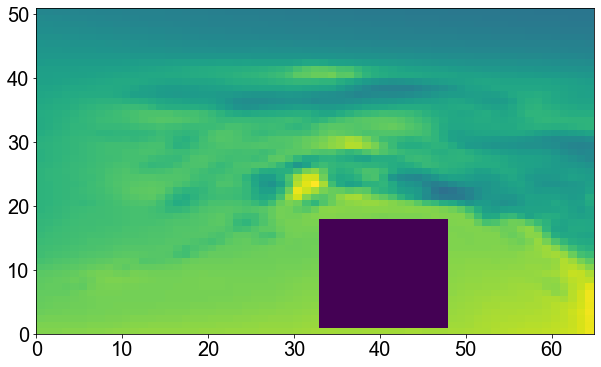

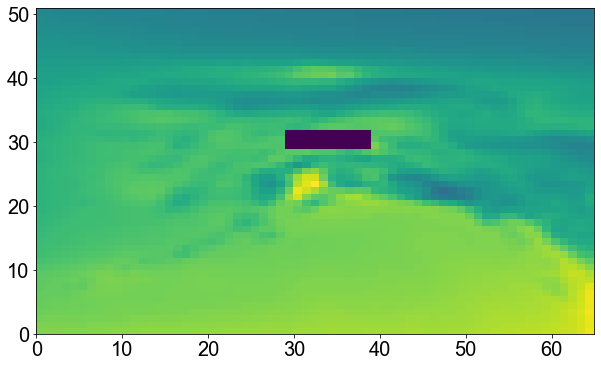

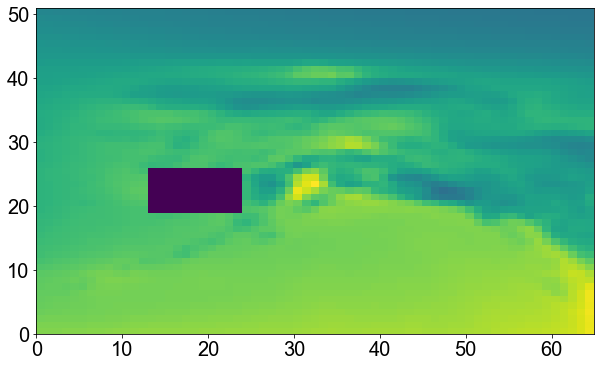

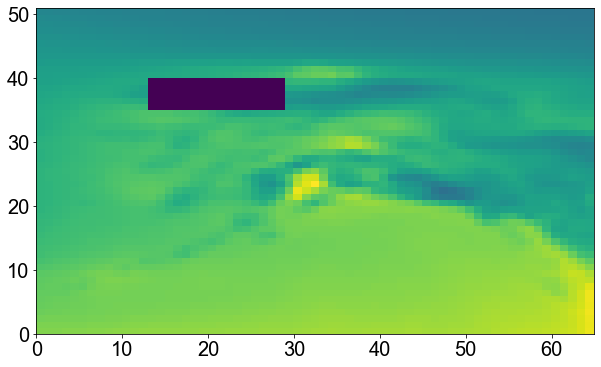

In [16]:
for imask in [mask_northPC, mask_centralAK, mask_swAK, mask_northslope]:
    plt.figure()
    plt.pcolormesh(HCHOVCD0_GC_18_NoWF.mean(dim='time')*~imask)

In [17]:
# function that calculate masked values
def mask_value(var, mask):
    tmp = (mask*var).where((mask*var) != 0)
    tmp_mask = (tmp).resample(time='1MS').mean(dim='time')
    value = tmp_mask.mean(dim='lat').mean(dim='lon')
    out_str_list = formstr(value.values)+"   mean: " + format( value.values.mean() ,'.2e')
    return out_str_list

def mask_value_percent(var1, var2, mask):
    tmp1 = (mask*var1).where((mask*var1) != 0)
    tmp2 = (mask*var2).where((mask*var2) != 0)
    tmp1_mask = (tmp1).resample(time='1MS').mean(dim='time')
    tmp2_mask = (tmp2).resample(time='1MS').mean(dim='time')
    value1 = tmp1_mask.mean(dim='lat').mean(dim='lon')
    value2 = tmp2_mask.mean(dim='lat').mean(dim='lon')
    out_str_list = formstr((value1.values)/(value2.values)*100)+" %    mean: " + format( ((value1.values)/(value2.values)).mean()*100 ,'.2f') + " %"
    return out_str_list

def mask_value_err(var, mask):
    f_err = lambda x: (x.resample(time='1MS').mean(dim='time'))/np.sqrt(x.resample(time='1MS').count(dim='time'))
    f_mm = lambda x: (x.resample(time='1MS').mean(dim='time'))
    
    tmp = (mask*var).where((mask*var) != 0)
    tmp_mask = f_err(tmp)
    value = tmp_mask.mean(dim='lat').mean(dim='lon')
    out_str_list = formstr(value.values)+"   mean: " + format( value.values.mean() ,'.2e')
    return out_str_list

def mask_value_percent_err(var1, var2, mask):
    
    f_err = lambda x: (x.resample(time='1MS').mean(dim='time'))/np.sqrt(x.resample(time='1MS').count(dim='time'))
    f_mm = lambda x: (x.resample(time='1MS').mean(dim='time'))

    tmp1 = (mask*var1).where((mask*var1) != 0)
    tmp2 = (mask*var2).where((mask*var2) != 0)
    tmp1_mask = f_err(tmp1)
    tmp2_mask = f_mm(tmp2)
    value1 = tmp1_mask.mean(dim='lat').mean(dim='lon')
    value2 = tmp2_mask.mean(dim='lat').mean(dim='lon')
    out_str_list = formstr((value1.values)/(value2.values)*100)+" %    mean: " + format( ((value1.values)/(value2.values)).mean()*100 ,'.2f') + " %"
    return out_str_list

In [18]:
############################################################################
########    Calculate GEOS-Chem VCD based on Pure Background, 2019
############################################################################

HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon = selnoon(HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF, hour1, hour2, 2019)
tmp_GCdVCD_fire_19 = HCHOVCD_GC_19_WF_noon - HCHOVCD_GC_19_NoWF_noon
HCHOVCD0_GC_19_NoWF_noon = selnoon(HCHOVCD0_GC_19_NoWF, hour1, hour2, 2019)

# central Alaska values in 2018 summer
tmp = mask_value(HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon, mask_centralAK)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value(HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon, mask_northPC)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon, mask_northslope)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon, mask_swAK)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, southwest AK")


##################     percentage of TROPOMI VCD     #########################


# central Alaska values in 2018 summer
tmp = mask_value_percent(  HCHOVCD0_GC_19_NoWF_noon - HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon  ,   tmp_GCdVCD_fire_19, mask_centralAK)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_percent(  HCHOVCD0_GC_19_NoWF_noon - HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon  ,   tmp_GCdVCD_fire_19, mask_northPC)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_percent(   HCHOVCD0_GC_19_NoWF_noon - HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon  ,   tmp_GCdVCD_fire_19, mask_northslope)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_percent(   HCHOVCD0_GC_19_NoWF_noon - HCHOVCD_GC_19_NoBVOC_NoWF_BCNoWF_noon  ,   tmp_GCdVCD_fire_19, mask_swAK)
print("GC VCD using Pure BC is "+ tmp + "      , 2019, southwest AK")

GC VCD using Pure BC is ['1.94e+15', '2.4e+15', '2.73e+15', '1.8e+15']   mean: 2.22e+15      , 2019, central AK
GC VCD using Pure BC is ['1.7e+15', '2.05e+15', '2.35e+15', '2.12e+15']   mean: 2.06e+15      , 2019, north PC
GC VCD using Pure BC is ['1.23e+15', '1.49e+15', '1.78e+15', '1.07e+15']   mean: 1.40e+15      , 2019, north Slope
GC VCD using Pure BC is ['1.48e+15', '2.01e+15', '2.33e+15', '1.71e+15']   mean: 1.88e+15      , 2019, southwest AK
GC VCD using Pure BC is ['63.3', '1.44', '0.364', '1.23e+03'] %    mean: 322.67 %      , 2019, central AK
GC VCD using Pure BC is ['2.23e+05', '133', '117', '1.23e+03'] %    mean: 56076.54 %      , 2019, north PC
GC VCD using Pure BC is ['2.29e+03', '151', '52.4', '3.17e+05'] %    mean: 79851.52 %      , 2019, north Slope
GC VCD using Pure BC is ['2.59e+03', '9.52', '3.33', '1.64e+03'] %    mean: 1059.55 %      , 2019, southwest AK


In [19]:
############################################################################
########    Calculate GEOS-Chem Background VCD0   2018
############################################################################

HCHOVCD0_GC_18_NoWF_noon = selnoon(HCHOVCD0_GC_18_NoWF, hour1, hour2, 2018)

# central Alaska values in 2018 summer
tmp = mask_value(HCHOVCD0_GC_18_NoWF_noon, mask_centralAK)
print("Background is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value(HCHOVCD0_GC_18_NoWF_noon, mask_northPC)
print("Background is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( HCHOVCD0_GC_18_NoWF_noon, mask_northslope)
print("Background is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD0_GC_18_NoWF_noon, mask_swAK)
print("Background is "+ tmp + "      , 2018, southwest AK")


##################     percentage of TROPOMI VCD     #########################


# central Alaska values in 2018 summer
tmp = mask_value_percent(HCHOVCD0_GC_18_NoWF_noon, HCHOVCD_TPM_18_new_noon, mask_centralAK)
print("Background is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value_percent(HCHOVCD0_GC_18_NoWF_noon, HCHOVCD_TPM_18_new_noon, mask_northPC)
print("Background is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value_percent( HCHOVCD0_GC_18_NoWF_noon, HCHOVCD_TPM_18_new_noon, mask_northslope)
print("Background is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value_percent( HCHOVCD0_GC_18_NoWF_noon, HCHOVCD_TPM_18_new_noon, mask_swAK)
print("Background is "+ tmp + "      , 2018, southwest AK")

Background is ['1.73e+15', '2.25e+15', '2.58e+15', '2.08e+15']   mean: 2.16e+15      , 2018, central AK
Background is ['1.62e+15', '2e+15', '2.43e+15', '2.78e+15']   mean: 2.21e+15      , 2018, north PC
Background is ['1.22e+15', '1.43e+15', '1.88e+15', '1.47e+15']   mean: 1.50e+15      , 2018, north Slope
Background is ['1.42e+15', '1.84e+15', '2.1e+15', '1.98e+15']   mean: 1.84e+15      , 2018, southwest AK
Background is ['72.7', '79.8', '74.7', '184'] %    mean: 102.89 %      , 2018, central AK
Background is ['163', '136', '116', '134'] %    mean: 137.10 %      , 2018, north PC
Background is ['79.9', '67.4', '91.8', '114'] %    mean: 88.38 %      , 2018, north Slope
Background is ['119', '108', '115', '231'] %    mean: 143.28 %      , 2018, southwest AK


In [20]:
############################################################################
########    Calculate GEOS-Chem Background VCD0   2019
############################################################################

HCHOVCD0_GC_19_NoWF_noon = selnoon(HCHOVCD0_GC_19_NoWF, hour1, hour2, 2019)

# central Alaska values in 2019 summer
tmp = mask_value(HCHOVCD0_GC_19_NoWF_noon, mask_centralAK)
print("Background is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value(HCHOVCD0_GC_19_NoWF_noon, mask_northPC)
print("Background is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( HCHOVCD0_GC_19_NoWF_noon, mask_northslope)
print("Background is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD0_GC_19_NoWF_noon, mask_swAK)
print("Background is "+ tmp + "      , 2019, southwest AK")


##################     percentage of TROPOMI VCD     #########################


# central Alaska values in 2019 summer
tmp = mask_value_percent(HCHOVCD0_GC_19_NoWF_noon, HCHOVCD_GC_19_WF_noon, mask_centralAK)
print("Background is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_percent(HCHOVCD0_GC_19_NoWF_noon, HCHOVCD_GC_19_WF_noon, mask_northPC)
print("Background is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_percent( HCHOVCD0_GC_19_NoWF_noon, HCHOVCD_GC_19_WF_noon, mask_northslope)
print("Background is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_percent( HCHOVCD0_GC_19_NoWF_noon, HCHOVCD_GC_19_WF_noon, mask_swAK)
print("Background is "+ tmp + "      , 2019, southwest AK")

Background is ['1.97e+15', '2.44e+15', '2.76e+15', '1.98e+15']   mean: 2.29e+15      , 2019, central AK
Background is ['1.75e+15', '2.09e+15', '2.39e+15', '2.63e+15']   mean: 2.21e+15      , 2019, north PC
Background is ['1.27e+15', '1.58e+15', '1.89e+15', '1.41e+15']   mean: 1.54e+15      , 2019, north Slope
Background is ['1.51e+15', '2.04e+15', '2.39e+15', '2.2e+15']   mean: 2.03e+15      , 2019, southwest AK
Background is ['88.5', '40.6', '22.1', '89.8'] %    mean: 60.24 %      , 2019, central AK
Background is ['99.9', '95.2', '93.8', '94.8'] %    mean: 95.93 %      , 2019, north PC
Background is ['98', '91.8', '85', '97.8'] %    mean: 93.17 %      , 2019, north Slope
Background is ['96.9', '76.8', '51.9', '94.7'] %    mean: 80.08 %      , 2019, southwest AK


In [21]:
############################################################################
########    Calculate TROPOMI VCD (total column)     2018
############################################################################

# central Alaska
tmp = mask_value( HCHOVCD_TPM_18_new_noon, mask_centralAK)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value( HCHOVCD_TPM_18_new_noon, mask_northPC)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( HCHOVCD_TPM_18_new_noon, mask_northslope)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD_TPM_18_new_noon, mask_swAK)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2018, southwest AK")



TROPOMI HCHO VCD is ['2.38e+15', '2.81e+15', '3.45e+15', '1.13e+15']   mean: 2.44e+15      , 2018, central AK
TROPOMI HCHO VCD is ['9.98e+14', '1.48e+15', '2.1e+15', '2.07e+15']   mean: 1.66e+15      , 2018, north PC
TROPOMI HCHO VCD is ['1.53e+15', '2.13e+15', '2.04e+15', '1.28e+15']   mean: 1.75e+15      , 2018, north Slope
TROPOMI HCHO VCD is ['1.19e+15', '1.7e+15', '1.82e+15', '8.6e+14']   mean: 1.39e+15      , 2018, southwest AK


In [22]:
############################################################################
########    Calculate TROPOMI dVCD   2018
############################################################################

tmp_TPMdVCD_18 = HCHOVCD_TPM_18_new_noon - HCHOVCD0_GC_18_NoWF_noon

# central Alaska
tmp = mask_value( tmp_TPMdVCD_18 , mask_centralAK)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2018, central AK")

# north Pacific
tmp = mask_value( tmp_TPMdVCD_18 , mask_northPC)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2018, north PC")

# north Slope
tmp = mask_value( tmp_TPMdVCD_18 , mask_northslope)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2018, north Slope")

# Southwest AK
tmp = mask_value( tmp_TPMdVCD_18 , mask_swAK)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2018, southwest AK")

TROPOMI HCHO dVCD is ['6.88e+14', '5.56e+14', '8.67e+14', '-8.61e+14']   mean: 3.13e+14      % , 2018, central AK
TROPOMI HCHO dVCD is ['-6.01e+14', '-4.54e+14', '-3.26e+14', '-6.26e+14']   mean: -5.02e+14      % , 2018, north PC
TROPOMI HCHO dVCD is ['3.45e+14', '6.53e+14', '1.12e+14', '-1.39e+14']   mean: 2.43e+14      % , 2018, north Slope
TROPOMI HCHO dVCD is ['-2.35e+14', '-1.04e+14', '-3.5e+14', '-9.69e+14']   mean: -4.15e+14      % , 2018, southwest AK


In [23]:
############################################################################
########    Calculate GEOS-Chem dVCD   2018
############################################################################ 

# central Alaska
tmp = mask_value( HCHOVCD_GC_18_WF_noon , mask_centralAK)
print("GC HCHO VCD is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value( HCHOVCD_GC_18_WF_noon , mask_northPC)
print("GC HCHO VCD is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( HCHOVCD_GC_18_WF_noon , mask_northslope)
print("GC HCHO VCD is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD_GC_18_WF_noon , mask_swAK)
print("GC HCHO VCD is "+ tmp + "      , 2018, southwest AK")

GC HCHO VCD is ['1.9e+15', '3.16e+15', '4.46e+15', '2.3e+15']   mean: 2.96e+15      , 2018, central AK
GC HCHO VCD is ['1.63e+15', '2.01e+15', '2.47e+15', '2.78e+15']   mean: 2.22e+15      , 2018, north PC
GC HCHO VCD is ['1.24e+15', '1.51e+15', '1.96e+15', '1.51e+15']   mean: 1.55e+15      , 2018, north Slope
GC HCHO VCD is ['1.47e+15', '2.11e+15', '2.21e+15', '2.04e+15']   mean: 1.96e+15      , 2018, southwest AK


In [24]:
############################################################################
########    Calculate GEOS-Chem dVCD   2018
############################################################################

tmp_GCdVCD_18_WF = HCHOVCD_GC_18_WF_noon - HCHOVCD0_GC_18_NoWF_noon

# central Alaska
tmp = mask_value( tmp_GCdVCD_18_WF , mask_centralAK)
print("GC HCHO dVCD is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_18_WF , mask_northPC)
print("GC HCHO dVCD is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_18_WF , mask_northslope)
print("GC HCHO dVCD is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_18_WF , mask_swAK)
print("GC HCHO dVCD is "+ tmp + "      , 2018, southwest AK")

GC HCHO dVCD is ['1.64e+14', '9.16e+14', '1.88e+15', '2.45e+14']   mean: 8.01e+14      , 2018, central AK
GC HCHO dVCD is ['3.71e+12', '1.24e+13', '3.71e+13', '5.79e+12']   mean: 1.47e+13      , 2018, north PC
GC HCHO dVCD is ['1.99e+13', '7.39e+13', '8.2e+13', '4.35e+13']   mean: 5.48e+13      , 2018, north Slope
GC HCHO dVCD is ['4.95e+13', '2.7e+14', '1.15e+14', '6.72e+13']   mean: 1.25e+14      , 2018, southwest AK


In [25]:
############################################################################
########    Calculate GEOS-Chem dVCD_wildfire     2018
############################################################################

tmp_GCdVCD_fire_18 = HCHOVCD_GC_18_WF_noon - HCHOVCD_GC_18_NoWF_noon

# central Alaska
tmp = mask_value( tmp_GCdVCD_fire_18 , mask_centralAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_fire_18 , mask_northPC)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_fire_18 , mask_northslope)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_fire_18 , mask_swAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, southwest AK")




#################################     percentage of GC dVCD     ###########################################
# central Alaska
tmp = mask_value_percent( tmp_GCdVCD_fire_18 ,HCHOVCD_GC_18_WF_noon , mask_centralAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value_percent( tmp_GCdVCD_fire_18 ,HCHOVCD_GC_18_WF_noon , mask_northPC)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value_percent( tmp_GCdVCD_fire_18 ,HCHOVCD_GC_18_WF_noon , mask_northslope)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value_percent( tmp_GCdVCD_fire_18 ,HCHOVCD_GC_18_WF_noon , mask_swAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2018, southwest AK")

GC HCHO dVCD_Fire is ['6.61e+12', '6.16e+14', '1.43e+15', '2.04e+13']   mean: 5.19e+14      , 2018, central AK
GC HCHO dVCD_Fire is ['3.04e+10', '5.81e+11', '2.26e+12', '3.35e+10']   mean: 7.26e+11      , 2018, north PC
GC HCHO dVCD_Fire is ['5.22e+11', '3.52e+13', '1.68e+13', '6.29e+12']   mean: 1.47e+13      , 2018, north Slope
GC HCHO dVCD_Fire is ['6.43e+10', '1.48e+14', '3.9e+12', '4.88e+10']   mean: 3.79e+13      , 2018, southwest AK
GC HCHO dVCD_Fire is ['0.349', '19.5', '32.1', '0.886'] %    mean: 13.21 %      , 2018, central AK
GC HCHO dVCD_Fire is ['0.00187', '0.0289', '0.0914', '0.00121'] %    mean: 0.03 %      , 2018, north PC
GC HCHO dVCD_Fire is ['0.0421', '2.33', '0.858', '0.417'] %    mean: 0.91 %      , 2018, north Slope
GC HCHO dVCD_Fire is ['0.00437', '6.99', '0.177', '0.00238'] %    mean: 1.79 %      , 2018, southwest AK


In [26]:
HCHOVCD_GC_18_WF_noon############################################################################
########    Calculate GEOS-Chem dVCD_bio     2018
############################################################################

tmp_GCdVCD_bio_18 = HCHOVCD_GC_18_NoWF_noon - HCHOVCD0_GC_18_NoWF_noon

# central Alaska
tmp = mask_value( tmp_GCdVCD_bio_18 , mask_centralAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_bio_18 , mask_northPC)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_bio_18 , mask_northslope)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_bio_18 , mask_swAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, southwest AK")



#################################     percentage of GC dVCD     ###########################################
# central Alaska
tmp = mask_value_percent( tmp_GCdVCD_bio_18 ,HCHOVCD_GC_18_WF_noon , mask_centralAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value_percent( tmp_GCdVCD_bio_18 ,HCHOVCD_GC_18_WF_noon , mask_northPC)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value_percent( tmp_GCdVCD_bio_18 ,HCHOVCD_GC_18_WF_noon , mask_northslope)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value_percent( tmp_GCdVCD_bio_18 ,HCHOVCD_GC_18_WF_noon , mask_swAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2018, southwest AK")

GC HCHO dVCD_Bio is ['1.58e+14', '3e+14', '4.47e+14', '2.24e+14']   mean: 2.82e+14      , 2018, central AK
GC HCHO dVCD_Bio is ['3.68e+12', '1.18e+13', '3.48e+13', '5.75e+12']   mean: 1.40e+13      , 2018, north PC
GC HCHO dVCD_Bio is ['1.94e+13', '3.88e+13', '6.52e+13', '3.7e+13']   mean: 4.01e+13      , 2018, north Slope
GC HCHO dVCD_Bio is ['4.94e+13', '1.22e+14', '1.11e+14', '6.72e+13']   mean: 8.74e+13      , 2018, southwest AK
GC HCHO dVCD_Bio is ['8.32', '9.47', '10', '9.73'] %    mean: 9.38 %      , 2018, central AK
GC HCHO dVCD_Bio is ['0.226', '0.586', '1.41', '0.207'] %    mean: 0.61 %      , 2018, north PC
GC HCHO dVCD_Bio is ['1.56', '2.57', '3.33', '2.45'] %    mean: 2.48 %      , 2018, north Slope
GC HCHO dVCD_Bio is ['3.36', '5.8', '5.01', '3.28'] %    mean: 4.36 %      , 2018, southwest AK


In [27]:
############################################################################
########    Calculate TROPOMI VCD (total column)     2019
############################################################################

# central Alaska
tmp = mask_value( HCHOVCD_TPM_19_new_noon, mask_centralAK)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value( HCHOVCD_TPM_19_new_noon, mask_northPC)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( HCHOVCD_TPM_19_new_noon, mask_northslope)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD_TPM_19_new_noon, mask_swAK)
print("TROPOMI HCHO VCD is "+ tmp + "      , 2019, southwest AK")




TROPOMI HCHO VCD is ['3.06e+15', '3.95e+15', '8.69e+15', '1.91e+15']   mean: 4.40e+15      , 2019, central AK
TROPOMI HCHO VCD is ['1.61e+15', '1.51e+15', '1.78e+15', '2.53e+15']   mean: 1.86e+15      , 2019, north PC
TROPOMI HCHO VCD is ['1.59e+15', '1.92e+15', '2.01e+15', '1.24e+15']   mean: 1.69e+15      , 2019, north Slope
TROPOMI HCHO VCD is ['1.23e+15', '2.1e+15', '4.53e+15', '2.03e+15']   mean: 2.47e+15      , 2019, southwest AK


In [28]:
############################################################################
########    Calculate TROPOMI dVCD   2019
############################################################################

tmp_TPMdVCD_19 = HCHOVCD_TPM_19_new_noon - HCHOVCD0_GC_19_NoWF

# central Alaska
tmp = mask_value( tmp_TPMdVCD_19 , mask_centralAK)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2019, central AK")

# north Pacific
tmp = mask_value( tmp_TPMdVCD_19 , mask_northPC)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2019, north PC")

# north Slope
tmp = mask_value( tmp_TPMdVCD_19 , mask_northslope)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2019, north Slope")

# Southwest AK
tmp = mask_value( tmp_TPMdVCD_19 , mask_swAK)
print("TROPOMI HCHO dVCD is "+ tmp + "      % , 2019, southwest AK")

TROPOMI HCHO dVCD is ['1.09e+15', '1.53e+15', '5.9e+15', '-3.45e+13']   mean: 2.12e+15      % , 2019, central AK
TROPOMI HCHO dVCD is ['-7.26e+13', '-5.12e+14', '-5.29e+14', '-1.59e+13']   mean: -2.83e+14      % , 2019, north PC
TROPOMI HCHO dVCD is ['2.66e+14', '3.39e+14', '4.75e+13', '-1.1e+14']   mean: 1.36e+14      % , 2019, north Slope
TROPOMI HCHO dVCD is ['-2.85e+14', '5.36e+13', '2.06e+15', '-7.17e+13']   mean: 4.38e+14      % , 2019, southwest AK


In [29]:
############################################################################
########    Calculate GEOS-Chem dVCD   2019
############################################################################ 

# central Alaska
tmp = mask_value( HCHOVCD_GC_19_WF_noon , mask_centralAK)
print("GC HCHO VCD is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value( HCHOVCD_GC_19_WF_noon , mask_northPC)
print("GC HCHO VCD is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( HCHOVCD_GC_19_WF_noon , mask_northslope)
print("GC HCHO VCD is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( HCHOVCD_GC_19_WF_noon , mask_swAK)
print("GC HCHO VCD is "+ tmp + "      , 2019, southwest AK")

GC HCHO VCD is ['2.23e+15', '6.02e+15', '1.25e+16', '2.21e+15']   mean: 5.73e+15      , 2019, central AK
GC HCHO VCD is ['1.75e+15', '2.19e+15', '2.54e+15', '2.77e+15']   mean: 2.32e+15      , 2019, north PC
GC HCHO VCD is ['1.3e+15', '1.72e+15', '2.22e+15', '1.44e+15']   mean: 1.67e+15      , 2019, north Slope
GC HCHO VCD is ['1.55e+15', '2.66e+15', '4.61e+15', '2.32e+15']   mean: 2.79e+15      , 2019, southwest AK


In [30]:
############################################################################
########    Calculate GEOS-Chem dVCD   2019
############################################################################

tmp_GCdVCD_19_WF = HCHOVCD_GC_19_WF_noon - HCHOVCD0_GC_19_NoWF

# central Alaska
tmp = mask_value( tmp_GCdVCD_19_WF , mask_centralAK)
print("GC HCHO dVCD is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_19_WF , mask_northPC)
print("GC HCHO dVCD is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_19_WF , mask_northslope)
print("GC HCHO dVCD is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_19_WF , mask_swAK)
print("GC HCHO dVCD is "+ tmp + "      , 2019, southwest AK")

GC HCHO dVCD is ['2.57e+14', '3.58e+15', '9.71e+15', '2.26e+14']   mean: 3.44e+15      , 2019, central AK
GC HCHO dVCD is ['2.07e+12', '1.06e+14', '1.56e+14', '1.44e+14']   mean: 1.02e+14      , 2019, north PC
GC HCHO dVCD is ['2.55e+13', '1.41e+14', '3.33e+14', '3.17e+13']   mean: 1.33e+14      , 2019, north Slope
GC HCHO dVCD is ['4.78e+13', '6.17e+14', '2.22e+15', '1.23e+14']   mean: 7.51e+14      , 2019, southwest AK


In [31]:
############################################################################
########    Calculate GEOS-Chem dVCD_wildfire     2019
############################################################################

tmp_GCdVCD_fire_19 = HCHOVCD_GC_19_WF_noon - HCHOVCD_GC_19_NoWF_noon

# central Alaska
tmp = mask_value( tmp_GCdVCD_fire_19 , mask_centralAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_fire_19 , mask_northPC)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_fire_19 , mask_northslope)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_fire_19 , mask_swAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, southwest AK")




#################################     percentage of GC dVCD     ###########################################
# central Alaska
tmp = mask_value_percent( tmp_GCdVCD_fire_19 ,HCHOVCD_GC_19_WF_noon , mask_centralAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_percent( tmp_GCdVCD_fire_19 ,HCHOVCD_GC_19_WF_noon , mask_northPC)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_percent( tmp_GCdVCD_fire_19 ,HCHOVCD_GC_19_WF_noon , mask_northslope)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_percent( tmp_GCdVCD_fire_19 ,HCHOVCD_GC_19_WF_noon , mask_swAK)
print("GC HCHO dVCD_Fire is "+ tmp + "      , 2019, southwest AK")





GC HCHO dVCD_Fire is ['5.6e+13', '2.97e+15', '8.98e+15', '1.44e+13']   mean: 3.01e+15      , 2019, central AK
GC HCHO dVCD_Fire is ['2.19e+10', '2.44e+13', '3.41e+13', '4.15e+13']   mean: 2.50e+13      , 2019, north PC
GC HCHO dVCD_Fire is ['1.79e+12', '5.72e+13', '2.1e+14', '1.06e+11']   mean: 6.73e+13      , 2019, north Slope
GC HCHO dVCD_Fire is ['1.15e+12', '3.92e+14', '1.88e+15', '2.94e+13']   mean: 5.76e+14      , 2019, southwest AK
GC HCHO dVCD_Fire is ['2.51', '49.4', '72', '0.654'] %    mean: 31.14 %      , 2019, central AK
GC HCHO dVCD_Fire is ['0.00125', '1.11', '1.34', '1.49'] %    mean: 0.99 %      , 2019, north PC
GC HCHO dVCD_Fire is ['0.138', '3.33', '9.45', '0.00735'] %    mean: 3.23 %      , 2019, north Slope
GC HCHO dVCD_Fire is ['0.0738', '14.7', '40.9', '1.27'] %    mean: 14.23 %      , 2019, southwest AK


In [32]:
############################################################################
########    Calculate GEOS-Chem dVCD_bio     2019
############################################################################

tmp_GCdVCD_bio_19 = HCHOVCD_GC_19_NoWF_noon - HCHOVCD0_GC_19_NoWF

# central Alaska
tmp = mask_value( tmp_GCdVCD_bio_19 , mask_centralAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value( tmp_GCdVCD_bio_19 , mask_northPC)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value( tmp_GCdVCD_bio_19 , mask_northslope)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value( tmp_GCdVCD_bio_19 , mask_swAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, southwest AK")




#################################     percentage of GC dVCD     ###########################################
# central Alaska
tmp = mask_value_percent( tmp_GCdVCD_bio_19 ,HCHOVCD_GC_19_WF_noon , mask_centralAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_percent( tmp_GCdVCD_bio_19 ,HCHOVCD_GC_19_WF_noon , mask_northPC)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_percent( tmp_GCdVCD_bio_19 ,HCHOVCD_GC_19_WF_noon , mask_northslope)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_percent( tmp_GCdVCD_bio_19 ,HCHOVCD_GC_19_WF_noon , mask_swAK)
print("GC HCHO dVCD_Bio is "+ tmp + "      , 2019, southwest AK")

GC HCHO dVCD_Bio is ['2.01e+14', '6.05e+14', '7.29e+14', '2.11e+14']   mean: 4.37e+14      , 2019, central AK
GC HCHO dVCD_Bio is ['2.05e+12', '8.15e+13', '1.22e+14', '1.02e+14']   mean: 7.70e+13      , 2019, north PC
GC HCHO dVCD_Bio is ['2.38e+13', '8.38e+13', '1.23e+14', '3.16e+13']   mean: 6.54e+13      , 2019, north Slope
GC HCHO dVCD_Bio is ['4.66e+13', '2.25e+14', '3.34e+14', '9.36e+13']   mean: 1.75e+14      , 2019, southwest AK
GC HCHO dVCD_Bio is ['9.03', '10.1', '5.85', '9.56'] %    mean: 8.62 %      , 2019, central AK
GC HCHO dVCD_Bio is ['0.117', '3.72', '4.81', '3.68'] %    mean: 3.08 %      , 2019, north PC
GC HCHO dVCD_Bio is ['1.83', '4.87', '5.51', '2.19'] %    mean: 3.60 %      , 2019, north Slope
GC HCHO dVCD_Bio is ['3', '8.46', '7.25', '4.04'] %    mean: 5.69 %      , 2019, southwest AK


In [33]:
############################################################################
########    Calculate TROPOMI dSCD error     2019
############################################################################

HCHOSCD_corr_Trueness_TPM_19_noon = selnoon(HCHOSCD_corr_Trueness_TPM_19, hour1, hour2, 2019)
HCHOSCD_corr_TPM_19_noon = selnoon(HCHOSCD_corr_TPM_19, hour1, hour2, 2019)

# central Alaska
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_19_noon, mask_centralAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_19_noon, mask_northPC)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_19_noon, mask_northslope)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_19_noon, mask_swAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, southwest AK")

#################################     percentage of TROPOMI VCD     ###########################################
# central Alaska
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_19_noon ,HCHOSCD_corr_TPM_19_noon , mask_centralAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, central AK")

# north Pacific
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_19_noon ,HCHOSCD_corr_TPM_19_noon , mask_northPC)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, north PC")

# north Slope
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_19_noon ,HCHOSCD_corr_TPM_19_noon , mask_northslope)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, north Slope")

# Southwest AK
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_19_noon ,HCHOSCD_corr_TPM_19_noon , mask_swAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2019, southwest AK")



TROPOMI HCHO dSCD Trueness is ['1.61e+14', '1.79e+14', '2.44e+14', '5.78e+14']   mean: 2.90e+14      , 2019, central AK
TROPOMI HCHO dSCD Trueness is ['1.68e+14', '1.71e+14', '1.72e+14', '4.75e+14']   mean: 2.46e+14      , 2019, north PC
TROPOMI HCHO dSCD Trueness is ['1.71e+14', '1.6e+14', '1.68e+14', '4.62e+14']   mean: 2.40e+14      , 2019, north Slope
TROPOMI HCHO dSCD Trueness is ['1.44e+14', '1.45e+14', '1.94e+14', '6.79e+14']   mean: 2.90e+14      , 2019, southwest AK
TROPOMI HCHO dSCD Trueness is ['11.7', '12.5', '5.41', '-364'] %    mean: -83.52 %      , 2019, central AK
TROPOMI HCHO dSCD Trueness is ['-67.8', '-16.3', '-16.8', '-529'] %    mean: -157.38 %      , 2019, north PC
TROPOMI HCHO dSCD Trueness is ['36.1', '31.7', '-1.11e+03', '-123'] %    mean: -291.22 %      , 2019, north Slope
TROPOMI HCHO dSCD Trueness is ['-24.2', '-172', '14.9', '-375'] %    mean: -139.04 %      , 2019, southwest AK


In [34]:
############################################################################
########    Calculate TROPOMI dSCD error     2018
############################################################################

HCHOSCD_corr_Trueness_TPM_18_noon = selnoon(HCHOSCD_corr_Trueness_TPM_18, hour1, hour2, 2018)
HCHOSCD_corr_TPM_18_noon = selnoon(HCHOSCD_corr_TPM_18, hour1, hour2, 2018)

# central Alaska
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_18_noon, mask_centralAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_18_noon, mask_northPC)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_18_noon, mask_northslope)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value_err( HCHOSCD_corr_Trueness_TPM_18_noon, mask_swAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, southwest AK")

#################################     percentage of TROPOMI VCD     ###########################################
# central Alaska
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_18_noon ,HCHOSCD_corr_TPM_18_noon , mask_centralAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, central AK")

# north Pacific
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_18_noon ,HCHOSCD_corr_TPM_18_noon , mask_northPC)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, north PC")

# north Slope
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_18_noon ,HCHOSCD_corr_TPM_18_noon , mask_northslope)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, north Slope")

# Southwest AK
tmp = mask_value_percent_err( HCHOSCD_corr_Trueness_TPM_18_noon ,HCHOSCD_corr_TPM_18_noon , mask_swAK)
print("TROPOMI HCHO dSCD Trueness is "+ tmp + "      , 2018, southwest AK")


TROPOMI HCHO dSCD Trueness is ['2.12e+14', '1.81e+14', '1.75e+14', '2.36e+14']   mean: 2.01e+14      , 2018, central AK
TROPOMI HCHO dSCD Trueness is ['2.18e+14', '1.63e+14', '1.67e+14', '1.87e+14']   mean: 1.84e+14      , 2018, north PC
TROPOMI HCHO dSCD Trueness is ['2.02e+14', '1.71e+14', '1.81e+14', '2.2e+14']   mean: 1.93e+14      , 2018, north Slope
TROPOMI HCHO dSCD Trueness is ['1.85e+14', '1.63e+14', '1.83e+14', '2.38e+14']   mean: 1.92e+14      , 2018, southwest AK
TROPOMI HCHO dSCD Trueness is ['22.2', '36.3', '28.9', '-16.3'] %    mean: 17.78 %      , 2018, central AK
TROPOMI HCHO dSCD Trueness is ['-18.8', '-18.9', '-27.2', '-16.7'] %    mean: -20.41 %      , 2018, north PC
TROPOMI HCHO dSCD Trueness is ['31.6', '17.1', '277', '-54.3'] %    mean: 67.83 %      , 2018, north Slope
TROPOMI HCHO dSCD Trueness is ['-38.5', '-51.9', '-21.4', '-12.3'] %    mean: -31.03 %      , 2018, southwest AK


In [72]:
# Calculate data in Toolik    vs    Angot 2020
#  1. Calculate monthly surface isoprene mixing ratio, in Toolik, 2018-07-15 to 2018-08-15
#  2. Calculate monthly surface isoprene mixing ratio, in Toolik, 2019-05-15 to 2019-06-30
# details: 
# 100km x 100km box --> Toolik
# GEOS-Chem surface layer (~50m) to represent surface
# 

latrange,lonrange = calbox(68.38,-149.36,100)

percent = selbox( (SpeciesConc_ISOP_18_WF[:,0,:,:].loc['2018-07-15T00:00:00':'2018-08-15T00:00:00'])*1e12 ).mean(dim='time')
print("Monthly mean Isoprene mixing ratio is  "+ str(percent.values) + " pptv in 2018 summer, Toolik")
percent = selbox( (SpeciesConc_MTPA_19_WF[:,0,:,:].loc['2019-05-15T00:00:00':'2019-06-30T00:00:00'])*1e12 ).mean(dim='time')
print("Monthly mean Mono mixing ratio is  "+ str(percent.values) + " pptv in 2019 summer, Toolik")

Monthly mean Isoprene mixing ratio is  456.59723 pptv in 2018 summer, Toolik
Monthly mean Mono mixing ratio is  10.219363 pptv in 2019 summer, Toolik


In [64]:
# look at AMF difference and relationship with a priori

TPM_AvKapri_18 = xr.open_dataset(jndir+"TROPOMI_AvKapri_GCHiR_hr_18_Fullrange.nc", engine="netcdf4")

AveragingKernel_TPM_18 = TPM_AvKapri_18["AveragingKernel_TPM_GCHiR"]
apriori_TPM_18 = TPM_AvKapri_18["apriori_TPM_GCHiR"]

latrange,lonrange = calbox(64.8,-147.7,100)
apriori_TPM_18_FA = selbox(apriori_TPM_18)
AveragingKernel_TPM_18_FA = selbox(AveragingKernel_TPM_18)
latrange,lonrange = calbox(64.8,-147.7,100)
SpeciesConc_CH2O_18_WF_FA = selbox(SpeciesConc_CH2O_18_WF)


# look at AMF difference and relationship with a priori

TPM_AvKapri_19 = xr.open_dataset(jndir+"TROPOMI_AvKapri_GCHiR_hr_19_Fullrange.nc", engine="netcdf4")

AveragingKernel_TPM_19 = TPM_AvKapri_19["AveragingKernel_TPM_GCHiR"]
apriori_TPM_19 = TPM_AvKapri_19["apriori_TPM_GCHiR"]

latrange,lonrange = calbox(64.8,-147.7,100)
apriori_TPM_19_FA = selbox(apriori_TPM_19)
AveragingKernel_TPM_19_FA = selbox(AveragingKernel_TPM_19)
latrange,lonrange = calbox(64.8,-147.7,100)
SpeciesConc_CH2O_19_WF_FA = selbox(SpeciesConc_CH2O_19_WF)

In [65]:
# extract Fairbanks timeseries
SpeciesConc_CH2O_18_NoWF_FA = selbox(SpeciesConc_CH2O_18_NoWF)
SpeciesConc_CH2O_18_NoBVOC_NoWF_FA = selbox(SpeciesConc_CH2O_18_NoBVOC_NoWF)

SpeciesConc_CH2O_19_NoWF_FA = selbox(SpeciesConc_CH2O_19_NoWF)
SpeciesConc_CH2O_19_NoBVOC_NoWF_FA = selbox(SpeciesConc_CH2O_19_NoBVOC_NoWF)

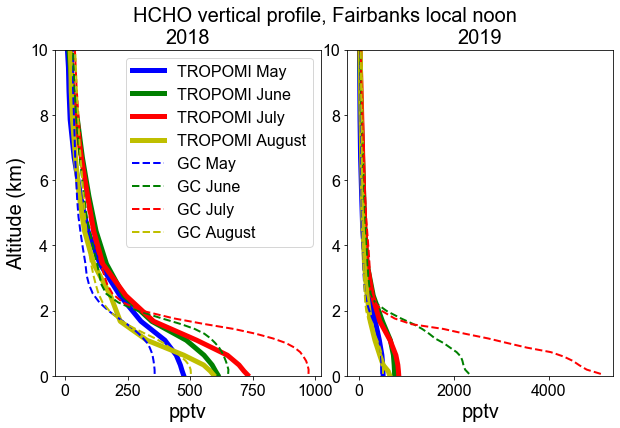

In [66]:
from cycler import cycler
import gcpy.plot as gcplot

H_b_TPM = H_b_gc[0:33].interp(lev=apriori_TPM_18_FA.lev[0:22], kwargs={'fill_value': 'extrapolate'})

fig = plt.figure()
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16) 
plt.rcParams['figure.figsize'] = (15.0, 7.0)

plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=(cycler(color=['b', 'g', 'r', 'y']) +
                           cycler(linestyle=['-', '-', '-', '-'])))

ax = fig.add_subplot(1,2,1, aspect='auto')

tmp = apriori_TPM_18_FA.resample(time="1MS").mean(dim='time').T*1e12
im1 = ax.plot(   tmp[0:22]  ,\
         H_b_TPM[0:22] ,lw=5)
#          tmp.lev ,lw=5)

tmp = selnoon(SpeciesConc_CH2O_18_WF_FA,hour1,hour2,2018).resample(time="1MS").mean(dim='time').T*1e12
im1 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'--',lw=2)
#          tmp.lev[0:33] ,'--',lw=2)

plt.title("2018",fontsize=20)
plt.gca().legend(('TROPOMI May','TROPOMI June','TROPOMI July', 'TROPOMI August',\
                  'GC May','GC June','GC July', 'GC August'),fontsize=16,loc='upper right')

# plt.xlim([0,3.5])
# ax.invert_yaxis()  #y轴反向
plt.ylim([0,10])
plt.xlabel("pptv",fontsize=20)
plt.ylabel("Altitude (km)",fontsize=20)

######################################################################


ax = fig.add_subplot(1,2,2, aspect='auto')


tmp = apriori_TPM_19_FA.resample(time="1MS").mean(dim='time')[1:,:].T*1e12
im2 = ax.plot(   tmp[0:22]  ,\
         H_b_TPM[0:22] ,lw=5)
#          tmp.lev ,lw=5)

tmp = selnoon(SpeciesConc_CH2O_19_WF_FA,hour1,hour2,2019).resample(time="1MS").mean(dim='time').T*1e12
im2 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'--',lw=2)
#          tmp.lev[0:33] ,'--',lw=2)

plt.title("2019",fontsize=20)



# plt.xlim([0,3.5])
# ax.invert_yaxis()  #y轴反向
plt.ylim([0,10])
plt.xlabel("pptv",fontsize=20)
# plt.ylabel("Sigma Coor",fontsize=20)
# plt.gca().legend(('TROPOMI May','TROPOMI June','TROPOMI July', 'TROPOMI August',\
#                   'GC May','GC June','GC July', 'GC August'),fontsize=16,loc='upper right')


plt.suptitle('HCHO vertical profile, Fairbanks local noon',fontsize=20)

# plt.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)#调整子图间距

plt.savefig('figs/apriori_GCvsTPM.png',dpi=300,bbox_inches='tight')

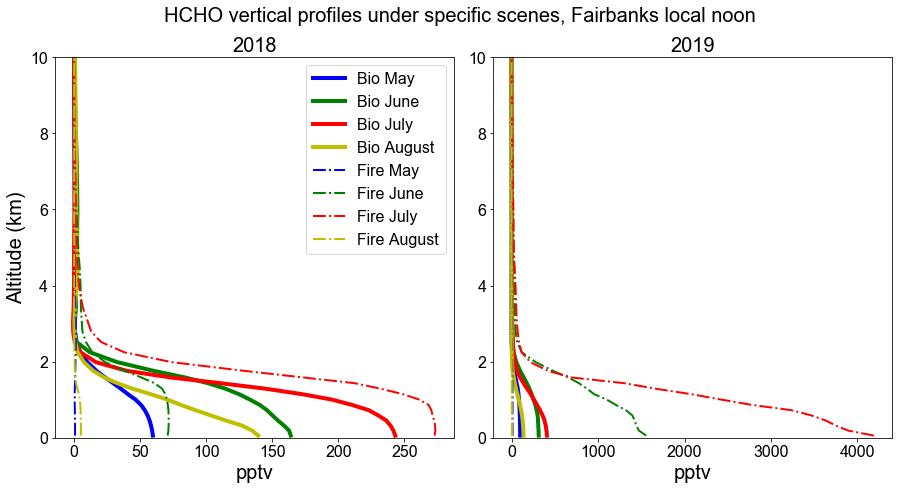

In [67]:
from cycler import cycler
import gcpy.plot as gcplot

H_b_TPM = H_b_gc[0:33].interp(lev=apriori_TPM_18_FA.lev[0:22], kwargs={'fill_value': 'extrapolate'})

fig = plt.figure()
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16) 
plt.rcParams['figure.figsize'] = (15.0, 7.0)

plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=(cycler(color=['b', 'g', 'r', 'y']) +
                           cycler(linestyle=['-', '-', '-', '-'])))

ax = fig.add_subplot(1,2,1, aspect='auto')

tmp = selnoon(   SpeciesConc_CH2O_18_NoWF_FA - SpeciesConc_CH2O_18_NoBVOC_NoWF_FA   ,hour1,hour2,2018).resample(time="1MS").mean(dim='time').T*1e12
im2 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'-',lw=4)
#          tmp.lev[0:33] ,'--',lw=2)

tmp = selnoon(  SpeciesConc_CH2O_18_WF_FA - SpeciesConc_CH2O_18_NoWF_FA  ,hour1,hour2,2018).resample(time="1MS").mean(dim='time').T*1e12
im1 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'-.',lw=2)
#          tmp.lev[0:33] ,'--',lw=2)

plt.title("2018",fontsize=20)



plt.gca().legend(('Bio May','Bio June','Bio July', 'Bio August',\
                  'Fire May','Fire June','Fire July', 'Fire August'),fontsize=16,loc='upper right')

# plt.xlim([0,3.5])
# ax.invert_yaxis()  #y轴反向
plt.ylim([0,10])
plt.xlabel("pptv",fontsize=20)
plt.ylabel("Altitude (km)",fontsize=20)

######################################################################


ax = fig.add_subplot(1,2,2, aspect='auto')

tmp = selnoon(   SpeciesConc_CH2O_19_NoWF_FA - SpeciesConc_CH2O_19_NoBVOC_NoWF_FA   ,hour1,hour2,2019).resample(time="1MS").mean(dim='time').T*1e12
im2 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'-',lw=4)
#          tmp.lev[0:33] ,'--',lw=2)

tmp = selnoon(  SpeciesConc_CH2O_19_WF_FA - SpeciesConc_CH2O_19_NoWF_FA  ,hour1,hour2,2019).resample(time="1MS").mean(dim='time').T*1e12
im2 = ax.plot(   tmp[0:33]  ,\
         H_b_gc[0:33] ,'-.',lw=2)
#          tmp.lev[0:33] ,'--',lw=2)

plt.title("2019",fontsize=20)



# plt.xlim([0,3.5])
# ax.invert_yaxis()  #y轴反向
plt.ylim([0,10])
plt.xlabel("pptv",fontsize=20)
# plt.ylabel("Sigma Coor",fontsize=20)
# plt.gca().legend(('TROPOMI May','TROPOMI June','TROPOMI July', 'TROPOMI August',\
#                   'GC May','GC June','GC July', 'GC August'),fontsize=16,loc='upper right')


plt.suptitle('HCHO vertical profiles under specific scenes, Fairbanks local noon',fontsize=20)

# plt.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)#调整子图间距

plt.savefig('figs/specific_apriori_GC.png',dpi=300,bbox_inches='tight')

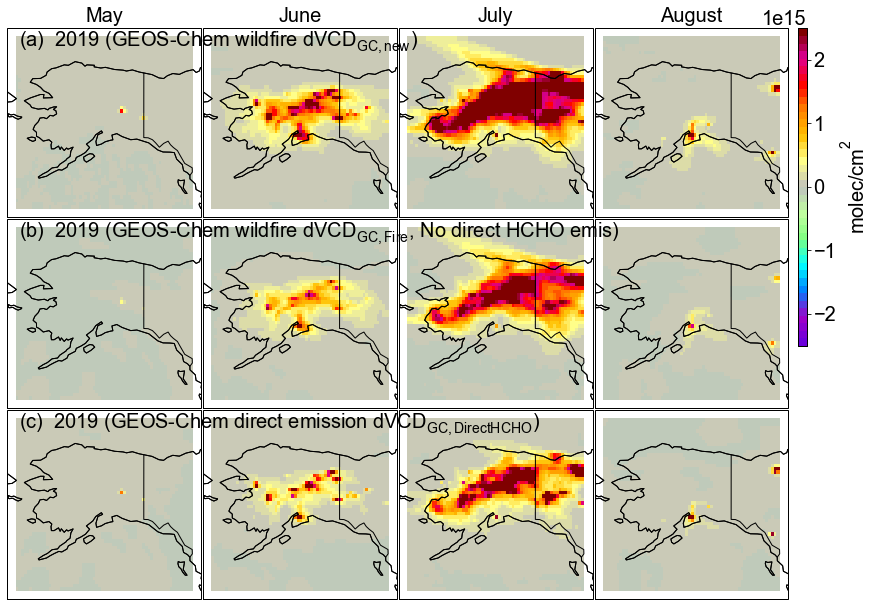

In [71]:
#####################################################################################################################
#               Direct Emission of HCHO
#####################################################################################################################



mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

ratioC = (12*5)/(12*5+8)



var = [
    selnoon(HCHOVCD_GC_19_WF - HCHOVCD_GC_19_NoWF         ,hour1,hour2,2019) ,\
    selnoon(HCHOVCD_GC_19_WEFHCHOoff - HCHOVCD0_GC_19_NoWF ,hour1,hour2,2019),\
    selnoon(HCHOVCD_GC_19_WF - HCHOVCD_GC_19_NoWF - HCHOVCD_GC_19_WEFHCHOoff + HCHOVCD0_GC_19_NoWF ,hour1,hour2,2019)
      ]


tmp_title = [
    
    "(a)  2019 (GEOS-Chem wildfire dVCD$\mathregular{_{GC,new}}$)",\
    "(b)  2019 (GEOS-Chem wildfire dVCD$\mathregular{_{GC,Fire}}$, No direct HCHO emis)",\
    "(c)  2019 (GEOS-Chem direct emission dVCD$\mathregular{_{GC,DirectHCHO}}$)",\
    "",\
    "",\
            ]

vminmax = [[-2.5e15,2.5e15],[-2.5e15,2.5e15],[-2.5e15,2.5e15]]
unitname= ["molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molecules/cm^2"]
cmapname = [cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,  cmaps.sunshine_9lev,  cmaps.NCV_jaisnd]
cbposition = [0.91, 0.46, 0.008, 0.42]   # 2 panels
proplot_mjja(var,tmp_title,vminmax,unitname,cmapname,cbposition)



# plt.savefig('figs/Ems-dVCD_1.png',dpi=300,bbox_inches='tight')

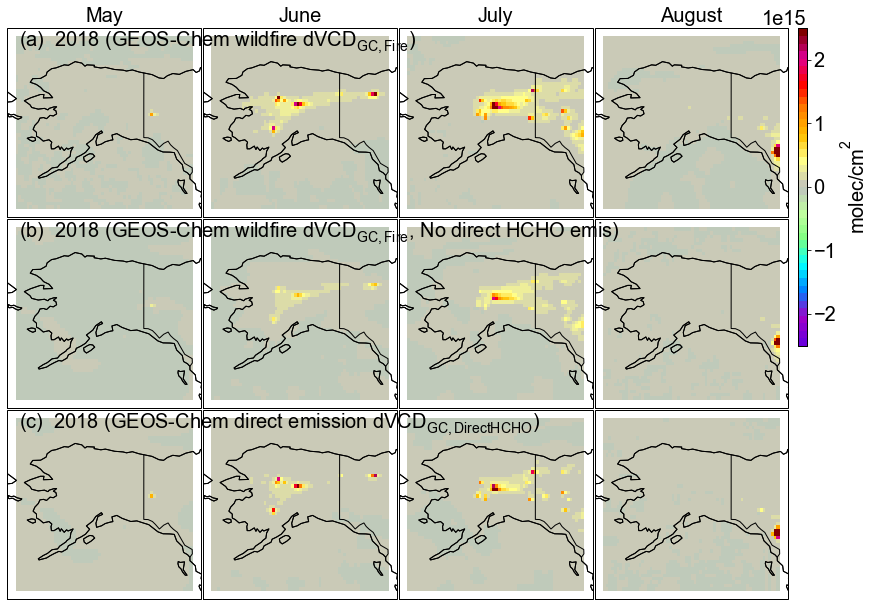

In [104]:
#####################################################################################################################
#               Direct Emission of HCHO   2018
#####################################################################################################################



mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

ratioC = (12*5)/(12*5+8)



var = [
    selnoon(HCHOVCD_GC_18_WF - HCHOVCD_GC_18_NoWF         ,hour1,hour2,2018) ,\
#     selnoon(HCHOVCD0_GC_18_WF - HCHOVCD0_GC_18_NoWF       ,hour1,hour2,2018) ,\
    selnoon(HCHOVCD_GC_18_WEFHCHOoff - HCHOVCD0_GC_18_NoWF ,hour1,hour2,2018),\
    selnoon(HCHOVCD_GC_18_WF - HCHOVCD_GC_18_NoWF - HCHOVCD_GC_18_WEFHCHOoff + HCHOVCD0_GC_18_NoWF ,hour1,hour2,2018)
      ]


tmp_title = [
    
    "(a)  2018 (GEOS-Chem wildfire dVCD$\mathregular{_{GC,Fire}}$)",\
    "(b)  2018 (GEOS-Chem wildfire dVCD$\mathregular{_{GC,Fire}}$, No direct HCHO emis)",\
    "(c)  2018 (GEOS-Chem direct emission dVCD$\mathregular{_{GC,DirectHCHO}}$)",\
    "",\
    "",\
            ]

vminmax = [[-2.5e15,2.5e15],[-2.5e15,2.5e15],[-2.5e15,2.5e15]]
unitname= ["molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molecules/cm^2"]
cmapname = [cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,cmaps.GHRSST_anomaly,  cmaps.sunshine_9lev,  cmaps.NCV_jaisnd]
cbposition = [0.91, 0.46, 0.008, 0.42]   # 2 panels
proplot_mjja(var,tmp_title,vminmax,unitname,cmapname,cbposition)



# plt.savefig('figs/Ems-dVCD_1.png',dpi=300,bbox_inches='tight')


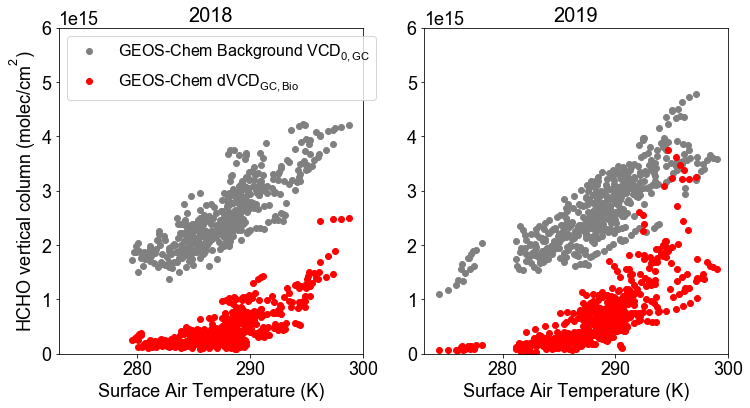

In [85]:
# Temperature dependence
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a* x**2+b*x +c

tmp_x = np.arange(270,300,2.5)

# Fairbanks    
latrange,lonrange = calbox(64.8,-147.7,100)

Met_SurfT_18_FA = selbox(Met_T_18[:,0,:,:])
Met_SurfT_19_FA = selbox(Met_T_19[:,0,:,:])

figsize = (12,6)
fig = plt.figure(figsize=figsize)


hour1 = 12+8
hour2 = 15+8
#######################   plot   ###########################
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)


ax = fig.add_subplot(1,2,1)

# Fairbanks, 2018
tmp_gcvcd0_noon = selnoon( HCHOVCD0_GC_18_NoWF_FA ,hour1,hour2,2018)
tmp_tpmnoon = selnoon( HCHOVCD_GC_18_NoWF_FA-HCHOVCD0_GC_18_NoWF_FA ,hour1,hour2,2018)
tmp_sftnoon = selnoon(Met_SurfT_18_FA,hour1,hour2,2018)

tt = tmp_gcvcd0_noon.time

im = ax.scatter(tmp_sftnoon.loc[tt] , tmp_gcvcd0_noon.loc[tt],   color='gray')  # GC
plt.scatter(tmp_sftnoon.loc[tt] , tmp_tpmnoon.loc[tt],   color='red')  # MAX-DOAS



plt.ylim([-0e15,6e15])
plt.xlim([273,300])
plt.xlabel("Surface Air Temperature (K)",fontsize=18)
plt.ylabel("HCHO vertical column (molec/$\mathregular{cm^2}$)",fontsize=18)

plt.title("2018",fontsize=20)
plt.gca().legend(('GEOS-Chem Background VCD$\mathregular{_{0,GC}}$',\
                  'GEOS-Chem dVCD$\mathregular{_{GC,Bio}}$'),fontsize=16,loc='upper left')


ax = fig.add_subplot(1,2,2)


# Fairbanks, 2019
tmp_gcvcd0_noon = selnoon( HCHOVCD0_GC_19_NoWF_FA ,hour1,hour2,2019)
tmp_tpmnoon = selnoon( HCHOVCD_GC_19_NoWF_FA-HCHOVCD0_GC_19_NoWF_FA ,hour1,hour2,2019)
tmp_sftnoon = selnoon(Met_SurfT_19_FA,hour1,hour2,2019)

tt = tmp_gcvcd0_noon.time

im = ax.scatter(tmp_sftnoon.loc[tt] , tmp_gcvcd0_noon.loc[tt],   color='gray')  # GC
plt.scatter(tmp_sftnoon.loc[tt] , tmp_tpmnoon.loc[tt],   color='red')  # MAX-DOAS


plt.ylim([-0e15,6e15])
plt.xlim([273,300])
plt.xlabel("Surface Air Temperature (K)",fontsize=18)
plt.title("2019",fontsize=20)

plt.savefig('figs/tempdepend_GCvsMD.png',dpi=300,bbox_inches='tight')